# Flexible Single Body Models (no rigid displacements)

The goal of this project is to consider flexible single body models. We assume the door to be a flexible bar (or plate) attached to the bus. We wish to take the structural properties of the door (deformation, strain and stress) into account. We assume (for simplicity) that the door is a linear (small displacement around point of equilibrium in which the door is closed) and homogeneous (constant Lame parameters or Youngs' modulus) elastic medium. We wish to compare e.g. a rigid door and flexible suspension (expect large rigid displacement of the door, recover previous cases) with a flexible door and stiff suspension (expect large deformation of the door, recover case of flexible bar attached to reference). 

As before, we aim at

1. a static analysis: one is typically interested in maximal displacements, accelarations and stresses. 

2. a transient (or vibration) analysis: one is interested in the motion of the bar or plate. In a transient analysis, some form of the wave-equation needs to be solved (vibrasting plate theory). Discretization is space can be performed using a finite difference or finite element method. Time-integration can be performed using DifferentialEquations.jl (or alternatives). 

3. an eigenmode analysis: one is interested in the shape modes of the system and the associated eigenfrequencies of the dynamical system. These eigenmodes can be used to  construct a reduced order model of the system. Such a reduced order model of model will facilitate modeling the impact of random excitations.

4. a random vibration analysis: one is interested in the response of a system due to a statistically varrying load; 

## Import Packages

In [1]:
using LinearAlgebra
using DifferentialEquations
using BoundaryValueDiffEq
using SparseArrays
using Plots
using BenchmarkTools 
using Gridap

## Section 1:/ Introduction 

### Theory 
We will use the finite element method for (non-)linear elastic media. For theory, geometry definition, mesh generation and references see [EE4375 Course](https://github.com/ziolai/finite_element_electrical_engineering). 

### Implementation 

#### Using Gridap 

#### Alternative Tools to use 
Possibly the tools listed below allow to compute reference solutions: 
1. [FinEtoolsFlexBeams](https://github.com/PetrKryslUCSD/FinEtoolsFlexBeamsTutorials.jl): includes vibrational analysis and assembly of beams;  
2. [EndoBeam.jl](https://gitlab.emse.fr/pierrat/EndoBeams.jl): package for beam-to-surface contact problems 
3. [GXBEAM](https://flow.byu.edu/GXBeam.jl/dev/): implementation of Geometrically Exact Beam Theory; includes vibrational analysis and assembly of beams; 
4. [the finite element package GridAp.jl](https://github.com/gridap/Gridap.jl) allows to describe the elastic deformation of flexible bodies. Can the double time-derivative be included? 

## Section 3: Bending Beam Supported on Both Sides  

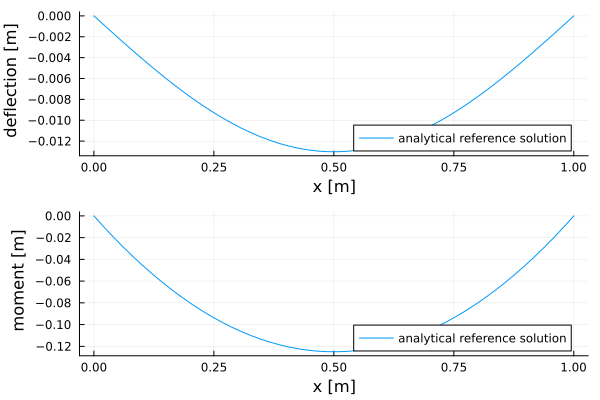

In [9]:
q = 1
EI = 1

x_vec = collect(range(0,1,50))

function deflection_fct(x)
    return -1/EI*x^4/24 + q/(12*EI)* x^3 - q/(24*EI)*x
end

function moment_fct(x)
    return 1/EI*x^2/2 - q/(2*EI)* x
end

deflection_ref = deflection_fct.(x_vec)

moment_ref = moment_fct.(x_vec)

p1 = plot(x_vec,deflection_ref, xlabel="x [m]", ylabel=" deflection [m]", label="analytical reference solution")

p2 = plot(x_vec,moment_ref, xlabel="x [m]", ylabel=" moment [m]", label="analytical reference solution")

plot(p1,p2, layout = (2,1))

## Section 3: Three-Point Bending Test 
See [wiki Euler–Bernoulli beam theory](https://en.wikipedia.org/wiki/Euler–Bernoulli_beam_theory). 

Exercise: change magnitude and location of the applied force.  

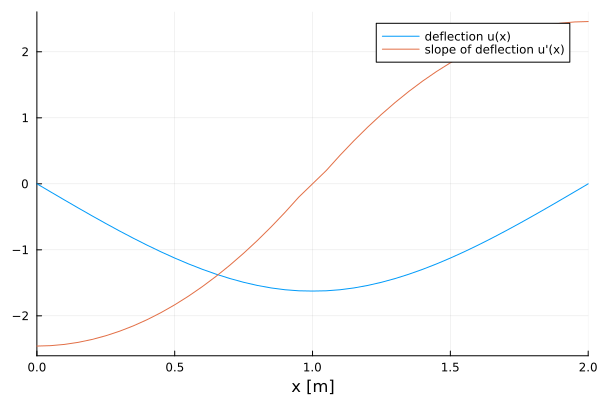

In [2]:
const P = 10.0 
L = 2.0
tspan = (0.0,L)
% 
function threepointbending!(du,u,p,t)
    w  = u[1]
    dw = u[2]
    du[1] = dw
    du[2] = P/2*t*(t<L/2)+P/2*(L-t)*(t>L/2)
end
% 
function bc1!(residual, u, p, t)
    residual[1] = u[1][1] # the solution at the middle of the time span should be -pi/2
    residual[2] = u[end][1]  # the solution at the end of the time span should be pi/2
end
% 
bvp1 = BVProblem(threepointbending!, bc1!, [1.,1.], tspan)
sol1 = solve(bvp1, GeneralMIRK4(), dt=0.05)
plot(sol1, xlabel="x [m]",label =["deflection u(x)" "slope of deflection u'(x)"])

## Section 4:/ Flexible Bar Models (aka Cantilever Beam)

Our aim here is to solve the (time-independent) [bi-harmonic equation](https://en.wikipedia.org/wiki/Biharmonic_equation) or in the (time-dependent) [beam equation](https://gitlab.emse.fr/pierrat/EndoBeams.jl). 

An analytical reference solution for the maximum deflection of a cantilevel beam with constant material coefficients is given in [using cantilever beam example for Euler–Bernoulli beam theory](https://en.wikipedia.org/wiki/Euler–Bernoulli_beam_theory)

An analytical reference solution for vibration of a cantilevel beam with constant material coefficients is given in [Vibration of Cantilever Beams](http://emweb.unl.edu/Mechanics-Pages/Scott-Whitney/325hweb/Beams.htm). 

In [3]:
# this example was provided by Oriol Colomes on the #gridal Slack channel on July 31st 
#module EB_beam # Euler-Bernouilli 
using Gridap
# model = CartesianDiscreteModel((0,1),(10))  # Domain from 0 to 1, discretized with 10 elements
model = CartesianDiscreteModel((0,1),(100))  # Domain from 0 to 1, discretized with 10 elements
Ω = Interior(model) # Triangulation
Λ = Skeleton(Ω)     # Triangulation of the skeleton (interior nodes) -> used in the CG/DG approach to enforce continuity of rotations weakly
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"left",[1,])  # Tag the left end node
add_tag_from_tags!(labels,"right",[2,]) # Tag the right end node (assume Free Neumann BC)
ΓD = Boundary(Ω,tags="left")
order = 1 # order = 2 # FE polynomial degree
refFE = ReferenceFE(lagrangian,Float64,order) # Lagrangian reference FE
V = TestFESpace(Ω,refFE,dirichlet_tags="left") # FE Space with Dirichlet BC at the left node
U = TrialFESpace(V,0.0) # Trial FE space with 0.0 deflection value at the Dirichlet BC
EI = 5.0e5 # Rigidity
h = 1/100   # Element size
γ = 1.0    # penalty constant
dΩ = Measure(Ω,2*order) # Integration measure for Ω
dΓ = Measure(ΓD,2*order) # Integration measure for ΓD
dΛ = Measure(Λ,2*order) # Integration measure for Λ
nΓ = get_normal_vector(ΓD) # normal vector at the boundary (this is a 1D vector in that case)
nΛ = get_normal_vector(Λ) # normal vector at the skeleton (this is a 1D vector in that case)
a(u,v) = ∫( EI*(Δ(u)*Δ(v)) )dΩ +
         ∫( EI * ( - Δ(u)*(∇(v)⋅nΓ) - (∇(u)⋅nΓ)*Δ(v) + γ/h*(∇(u)⋅nΓ)*(∇(v)⋅nΓ) ) )dΓ +
         ∫( EI * ( - Gridap::mean(Δ(u))*jump(∇(v)⋅nΛ) - jump(∇(u)⋅nΛ)*Gridap::mean(Δ(v)) + γ/h*jump(∇(u)⋅nΛ)*jump(∇(v)⋅nΛ) ) )dΛ
l(v) = ∫( -1.0*v )dΩ  # negative distributed force
op = AffineFEOperator(a,l,U,V)  # FE operator
uh = solve(op)
writevtk(Ω,"solution",cellfields=["u"=>uh])
#end

LoadError: UndefVarError: mean not defined

In [3]:
plot(uhdof,label="Displacement", fmt = :png)
xlabel!("x") 
ylabel!("displacement")

LoadError: UndefVarError: plot not defined

## Section 5:/ Flexible Plate Models 

An analytical reference solution for the maximum deflection of a for the plate using the [rectangular Kirchhoff-Love plate theory](https://en.wikipedia.org/wiki/Bending_of_plates). Shape modes for plates are documented in the literature. 

Using (non-)linear elasticity. 

- Linear elasticity tutorial in [GridAp](https://github.com/gridap/Gridap.jl): [tutorial-3](https://gridap.github.io/Tutorials/stable/pages/t003_elasticity/#Tutorial-3:-Linear-elasticity-1) 

- Non-Linear Elasticity Tutorial in [GridAp](https://github.com/gridap/Gridap.jl): [tutorial-5](https://gridap.github.io/Tutorials/stable/pages/t005_hyperelasticity/)

- Models previously developed by XiEngineering and how to extend them. 

## References 